In [1]:
import rasterio
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

## Read in the `austinlights.tif` file we made in the `rasters` notebook

In [2]:
nightlight_file = rasterio.open('../../data/austinlights.tif')
nightlights = nightlight_file.read(1)


## Make a `nightlights_extent` array containing the extent of the nightlight raster.

the `bounds` attribute from the `nightlight_file` will be helpful. 

In [3]:
nightlight_extent = numpy.asarray(nightlight_file.bounds)[[0,2,1,3]]

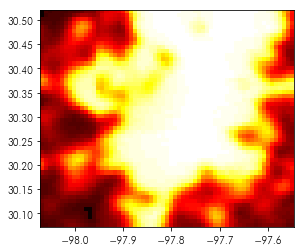

In [4]:
plt.imshow(nightlights, cmap='hot', extent=nightlight_extent)

## Read in the Ausin 311 data

In [5]:
reports = pandas.read_csv('../../data/austin_311.csv.gz')

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean the 311 data:

1. This time, we'll simply ignore the missing points. Drop the values with missing `latitude`, `longitude`, or `location` attributes. 
2. Keep only tickets whose `status` suggests they're reports with full information that are not duplicated. 
3. Remove impossible latitude/longitudes using the `nightlight_extent` you made earlier. 

In [6]:
reports = reports.dropna(subset=['longitude', 'latitude', 'location'])

In [7]:
to_drop = ('Duplicate (closed)', 'Closed -Incomplete Information', 'Duplicate (open)', 
           'TO BE DELETED', 'CancelledTesting', 'Closed -Incomplete', 'Incomplete')
reports = reports.query('status not in @to_drop')

In [8]:
too_far_ns = (reports.latitude < nightlight_extent[2]) | (reports.latitude > nightlight_extent[3])
too_far_we = (reports.longitude < nightlight_extent[0]) | (reports.longitude > nightlight_extent[1])
outside = too_far_ns | too_far_we

In [9]:
reports = reports[~outside]

## Make a geodataframe from the reports data

In [10]:
reports = geopandas.GeoDataFrame(reports, 
                                 geometry=geopandas.points_from_xy(reports.longitude, 
                                                                   reports.latitude))

## Identify whether your zipcodes are accurately coded
1. First, build a convex hull around points within the same area
2. Then, plot the convex hulls to see if they overlap/make sense. 

In [11]:
zipcodes = reports.groupby('zipcode').geometry\
                  .apply(lambda x: x.unary_union.convex_hull)

In [12]:
zipcodes = geopandas.GeoDataFrame(zipcodes)

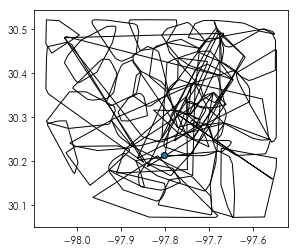

In [13]:
zipcodes.plot(ax=plt.gca(), facecolor='none', edgecolor='k')

## What is the highest, lowest, and median brightness within these three zipcodes?
1. 78705
2. 78702
3. 78701

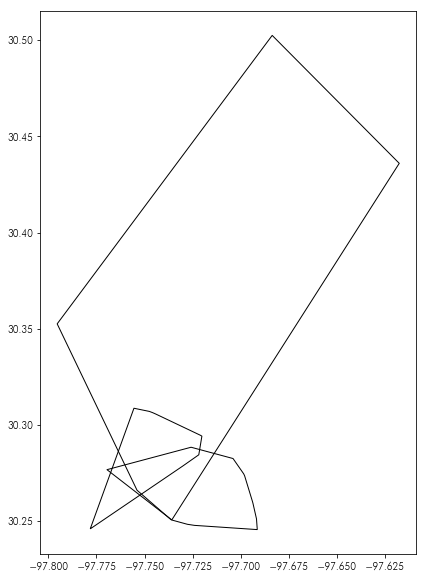

In [14]:
plt.figure(figsize=(10,10))
zipcodes.loc[[78705, 78702, 78701]].plot(ax=plt.gca(), facecolor='none', edgecolor='k')

In [15]:
targets = zipcodes.loc[[78705, 78702, 78701]]

In [16]:
from rasterio.mask import mask

In [17]:
def summarize_mask(geom, dataset=nightlight_file, **mask_kw):
    mask_kw.setdefault('crop', True)
    mask_kw.setdefault('filled', False)
    masked = mask(dataset=dataset, shapes=(geom,), **mask_kw)[0]
    return (masked.min(), numpy.ma.median(masked), masked.max())

In [18]:
targets.geometry.apply(summarize_mask)

zipcode
78705    (63, 63.0, 63)
78702    (62, 63.0, 63)
78701    (56, 63.0, 63)
Name: geometry, dtype: object

## What is the brightness at each of the streetlight issues in the 311 dataset?


In [19]:
streetlight_issues = reports.description.apply(lambda string: ('street light' in string.lower()))

In [20]:
streetlight_reports = reports[streetlight_issues]

In [21]:
brightnesses = nightlight_file.sample(streetlight_reports[['longitude', 'latitude']].values)

In [22]:
brightnesses = numpy.hstack(list(brightnesses))

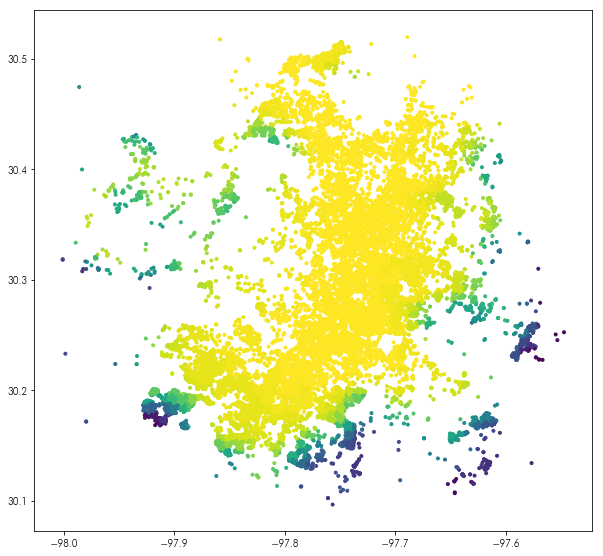

In [23]:
plt.figure(figsize=(10,10))
streetlight_reports.assign(brightness=brightnesses).plot('brightness', ax=plt.gca(), marker='.')

(array([0.00083984, 0.        , 0.00503905, 0.01455726, 0.01581703,
        0.02295568, 0.01651689, 0.01623695, 0.01651689, 0.01819658,
        0.02225582, 0.01189776, 0.00853839, 0.01021808, 0.00769855,
        0.00755858, 0.0079785 , 0.00741861, 0.00727863, 0.00643879,
        0.01203774, 0.00853839, 0.00867837, 0.00783853, 0.01119789,
        0.01203774, 0.01497718, 0.02071611, 0.02827468, 0.12793595]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ,
        23.1, 25.2, 27.3, 29.4, 31.5, 33.6, 35.7, 37.8, 39.9, 42. , 44.1,
        46.2, 48.3, 50.4, 52.5, 54.6, 56.7, 58.8, 60.9, 63. ]),
 <a list of 1 Patch objects>)

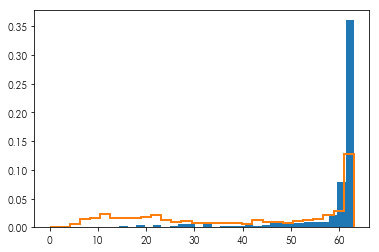

In [24]:
plt.hist(brightnesses, bins=30, density=True)
plt.hist(nightlights.flatten(), density=True,
         bins=30, histtype='step', linewidth=2)